# 量子神经网络？

上次讨论了量子机器学习框架TensorFlow Quantum的Hello World，这次看一下另一个应用：量子神经网络。

注：本文根据TensorFlow Quantum的MNIST示例整理：https://www.tensorflow.org/quantum/tutorials/mnist

这个示例是基于谷歌在2018年发表的一篇论文"Classification with Quantum Neural Networks on Near Term Processors"。
在这篇论文中，作者Farhi等人提出了将量子电路和神经网络的结合起来实现二元分类的一种方案，主要思路是这样：
- 将训练输入看作是二进制的字串，把其中每个比特转换成量子比特，例如0对应$|0\rangle$，1对应$|1\rangle$；
- 创建一个量子电路，输入端有N+1个量子比特，其中N个量子比特对应输入的字串长度，另有一个read out量子比特，用来输出分类结果；
- 量子电路内部，用一组带参数的门连接起来，具体用什么门以及如何连接，似乎没有特别的要求，在文章里作者经过试验选用了带参数的XX和ZZ门。每个门带有一个控制参数（例如${XX}^\alpha$）。如果量子电路有32个这样的门，那么就有32个参数需要学习；
- 把量子电路作为神经网络的一层，输入训练集和标签，学习控制参数。

整个训练过程大致如下：

把量子电路看作神经网络的一层，那么输入训练集里的字串，从它的read out那里读出分类结果，和训练标签比较，产生loss，然后反馈给神经网络进行梯度下降。经过训练，模型会学习到一组量子电路的参数，用这组参数控制量子电路，就能对未知的输入作出准确的分类预测。

<img src="./images/QNN MNIST.png" width=500 />

论文原文在这里：https://arxiv.org/pdf/1802.06002.pdf

这个思路看起来不难，可以用TensorFlow Quantum实现，实际上整个示例，模型部分是很简单的，主要工作在于数据处理。

因为目前的量子计算机和模拟器，对于量子比特的数量和量子电路的深度都有一定的限制，例如MNIST里的图片都是28x28，即使转换成黑白图像，也需要784个量子比特来代表输入，这显然是不现实的。所以在这个示例里，MNIST图像先要降低分辨率，然后要去掉重复，再去掉矛盾的标签，等等，经过一番处理，才能把输入送入模型进行训练。

接下来我们来看一下具体的代码。首先还是先引入要用的包。

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

读入数据，把每个像素从0-255转换为0-1之间的浮点数：

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


这个示例是二元分类，因此我们只选取3和6两个数字的图像进行分类：

In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


找一个图像画出来看一下：

True


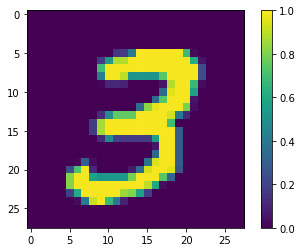

In [4]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

我们的电路一共只有十几个量子比特，因此要把输入图像降低分辨率到4x4:

In [6]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()
print(x_train_small.shape)

(12049, 4, 4, 1)


降低分辨率后，图像变成了这样：

True


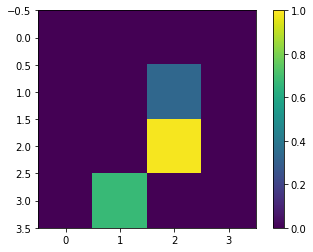

In [7]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

接下来一步在经典的机器学习里可能不太见到：训练集里有些标签是互相矛盾的，即有些图像既被标成3也被标成6，这里要把这些矛盾的去掉。

In [8]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of 3s:  4961
Number of 6s:  5475
Number of contradictory images:  49

Initial number of examples:  12049
Remaining non-contradictory examples:  11520


然后进一步处理，要把图像的每个像素变成0和1。这里就用一个简单的阈值0.5，超过0.5的就是1，否则就是0。

In [9]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

然后开始搭量子电路，首先是输入量子比特，根据像素是0还是1，准备对应的$|0\rangle$和$|1\rangle$:

In [10]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

In [11]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

继续搭建电路，接下来要加入连接的XX门，每个XX门带一个参数。

In [12]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

例如，如果输入是2x2的图像，那么我们有5个输入，电路是这样：（第一行那个就是read out）

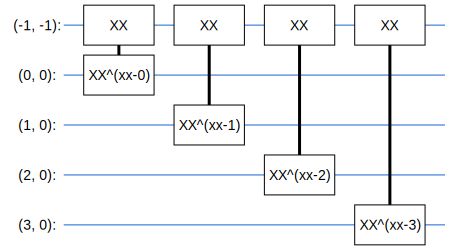

In [13]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

完整的电路有17个输入（4x4图像，加一个read out），作者用了16个XX门和16个ZZ门，因此一共有32个参数：

In [14]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [15]:
model_circuit, model_readout = create_quantum_model()

电路图画出来有点大。。。

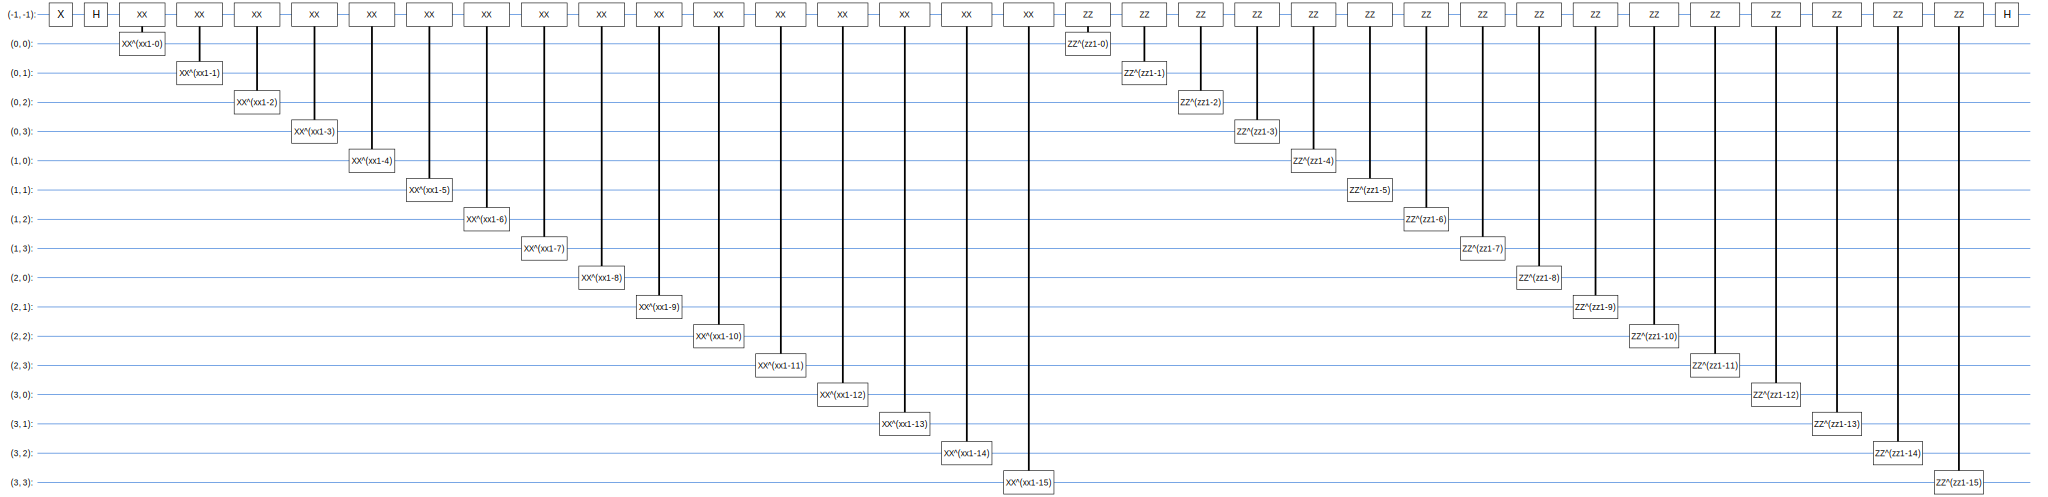

In [16]:
SVGCircuit(model_circuit)

然后，把量子电路接入到TensorFlow的神经网络模型里。量子电路用TensorFlow Quantum的PQC (Parameterized Quantum Circuit)封装，前文说到过，PQC的输出是期望值（-1到1之间）。

In [19]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    # model_readout is operator cirq.Z(readout)
    tfq.layers.PQC(model_circuit, model_readout),
])


但是现在还不能编译模型，为什么呢？因为输入的标签（y_train_nocon，y_test）都是布尔值0或者1，而我们的电路输出的是-1到1之间的期望值。所以要把标签转换成hinge：

In [20]:
# Labels in y_train_nocon/y_test are booleans, convert them to [-1,1]
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

我们也需要有对应hinge的accuracy函数（用作模型的metrics）：

In [21]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

接下来就可以编译模型了，还是用常见的Adam优化器，注意这里用的loss是Hinge：

In [22]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


模型搭建完成，接下来就可以训练了！（注：训练时间较长，3个epoch在笔记本上大概要十几分钟）

In [24]:
EPOCHS = 3
BATCH_SIZE = 32

# Previously defined:
# x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
# x_test_circ = [convert_to_circuit(x) for x in x_test_bin]
# Each pixel is a qubit, and if pixel is 0 it's |0> or else it's |1> (by applying X gate)
# x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
# x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

NUM_EXAMPLES = len(x_train_tfcirc)

# Use a smaller subset for shorter training, for example:
# NUM_EXAMPLES = 500

In [25]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
360/360 [==============================] - 260s 724ms/step - loss: 0.5884 - hinge_accuracy: 0.7721 - val_loss: 0.3951 - val_hinge_accuracy: 0.8135
Epoch 2/3
360/360 [==============================] - 269s 746ms/step - loss: 0.3551 - hinge_accuracy: 0.8803 - val_loss: 0.3362 - val_hinge_accuracy: 0.8579
Epoch 3/3
62/62 [==============================] - 5s 86ms/step - loss: 0.3402 - hinge_accuracy: 0.9068


可以看到，我们的量子神经网路经过3个epoch的训练，达到了90%的准确率。

**那么这个量子神经网络，如何同经典神经网络比较呢？**

首先量子神经网络只有32个参数，如果我们拿它去和几百万个参数的神经网络相比，显然是不公平的。所以这里我们构建一个37个参数的神经网络来做比较：

In [28]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=0,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

62/62 [==============================] - 0s 511us/step - loss: 0.2666 - accuracy: 0.9141


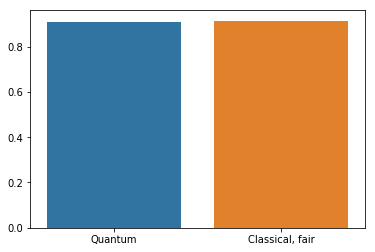

In [31]:
qnn_accuracy = qnn_results[1]
# cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, fair"],
            [qnn_accuracy, fair_nn_accuracy])

和类似规模的经典神经网络相比，准确率差不多。

总的来说，我感觉这个方案是量子计算在神经网络里的direct drop-in，很直观，但是如作者在论文中讨论的，应该有能够更好发挥量子计算内在并行性的方法。